# Interactive feature matching

In [1]:
import sys
sys.path.append('..')

from multiview_stitcher import spatial_image_utils as si_utils

from muvis_align.MVSRegistration import MVSRegistration
from muvis_align.util import dir_regex
from muvis_align.image.util import get_sim_physical_size, draw_keypoints_matches

## Setup parameters

In [2]:
params = {
	'general':
	{
        'ui': 'mpl',
        'debug': True
	},
	'operations':
	[
		{
			'operation': 'register',
			'input': [
                'D:/slides/EM04652-02_slice17_spaghettiandmeatballs2/stitched/slice00009/registered.ome.zarr',
                'D:/slides/EM04652-02_slice17_spaghettiandmeatballs2/stitched_hpc/slice00010/registered.ome.zarr'
                ],
			#'source_metadata': 'source',
            'source_metadata': {'position': {'y': 0, 'x': 0}, 'rotation': None},
            'use_orthogonal_pairs': True,
            'n_parallel_pairwise_regs': 1,
			'output': '../../output/'
		}
	]
}


## Initialise muvis-align, initialise sims, and pre-process

In [3]:
operation_params = params['operations'][0]
filenames = dir_regex(operation_params['input'])

reg = MVSRegistration(params['general'])
reg.init_operation('', filenames, operation_params)
sims = reg.init_sims()
norm_sims, _ = reg.preprocess(sims, operation_params)

for label, sim in zip(reg.file_labels, sims):
    print(label, si_utils.get_origin_from_sim(sim), get_sim_physical_size(sim))

slice00009 {'y': 0.0, 'x': 0.0} {'y': 758.6208849557588, 'x': 1011.4945132742869}
slice00010 {'y': 0.0, 'x': 0.0} {'y': 765.3999999993039, 'x': 1020.5299999990718}


## Get overlap between tiles

In [ ]:
%matplotlib inline
overlap1, overlap2 = reg.get_overlap_images(norm_sims[0], norm_sims[1], reg.source_transform_key)
#overlap1, overlap2 = overlap1.squeeze().compute(), overlap2.squeeze().compute()
overlap1, overlap2 = overlap1.squeeze(), overlap2.squeeze()
print('Overlap size [um]:', overlap1.shape * si_utils.get_spacing_from_sim(sims[0], asarray=True))

draw_keypoints_matches(overlap1, [], overlap2, [])

Overlap size [um]: [ 758.62088496 1011.49451327]


## Interactive: Set up feature extraction and matching, and show results

### You can modify the parameters and rerun this cell to update results, e.g.:

**transform_type**: affine, euclidean, translation

**name**: sift, orb

norm translation [ 0.00258269 -0.00089148] norm SD 8.019164789174448e-05
%inliers 0.8927835051546392 #good ransac iterations 3
#keypoints: 2144,2161 #matches: 485 #inliers: 433 quality: 0.442


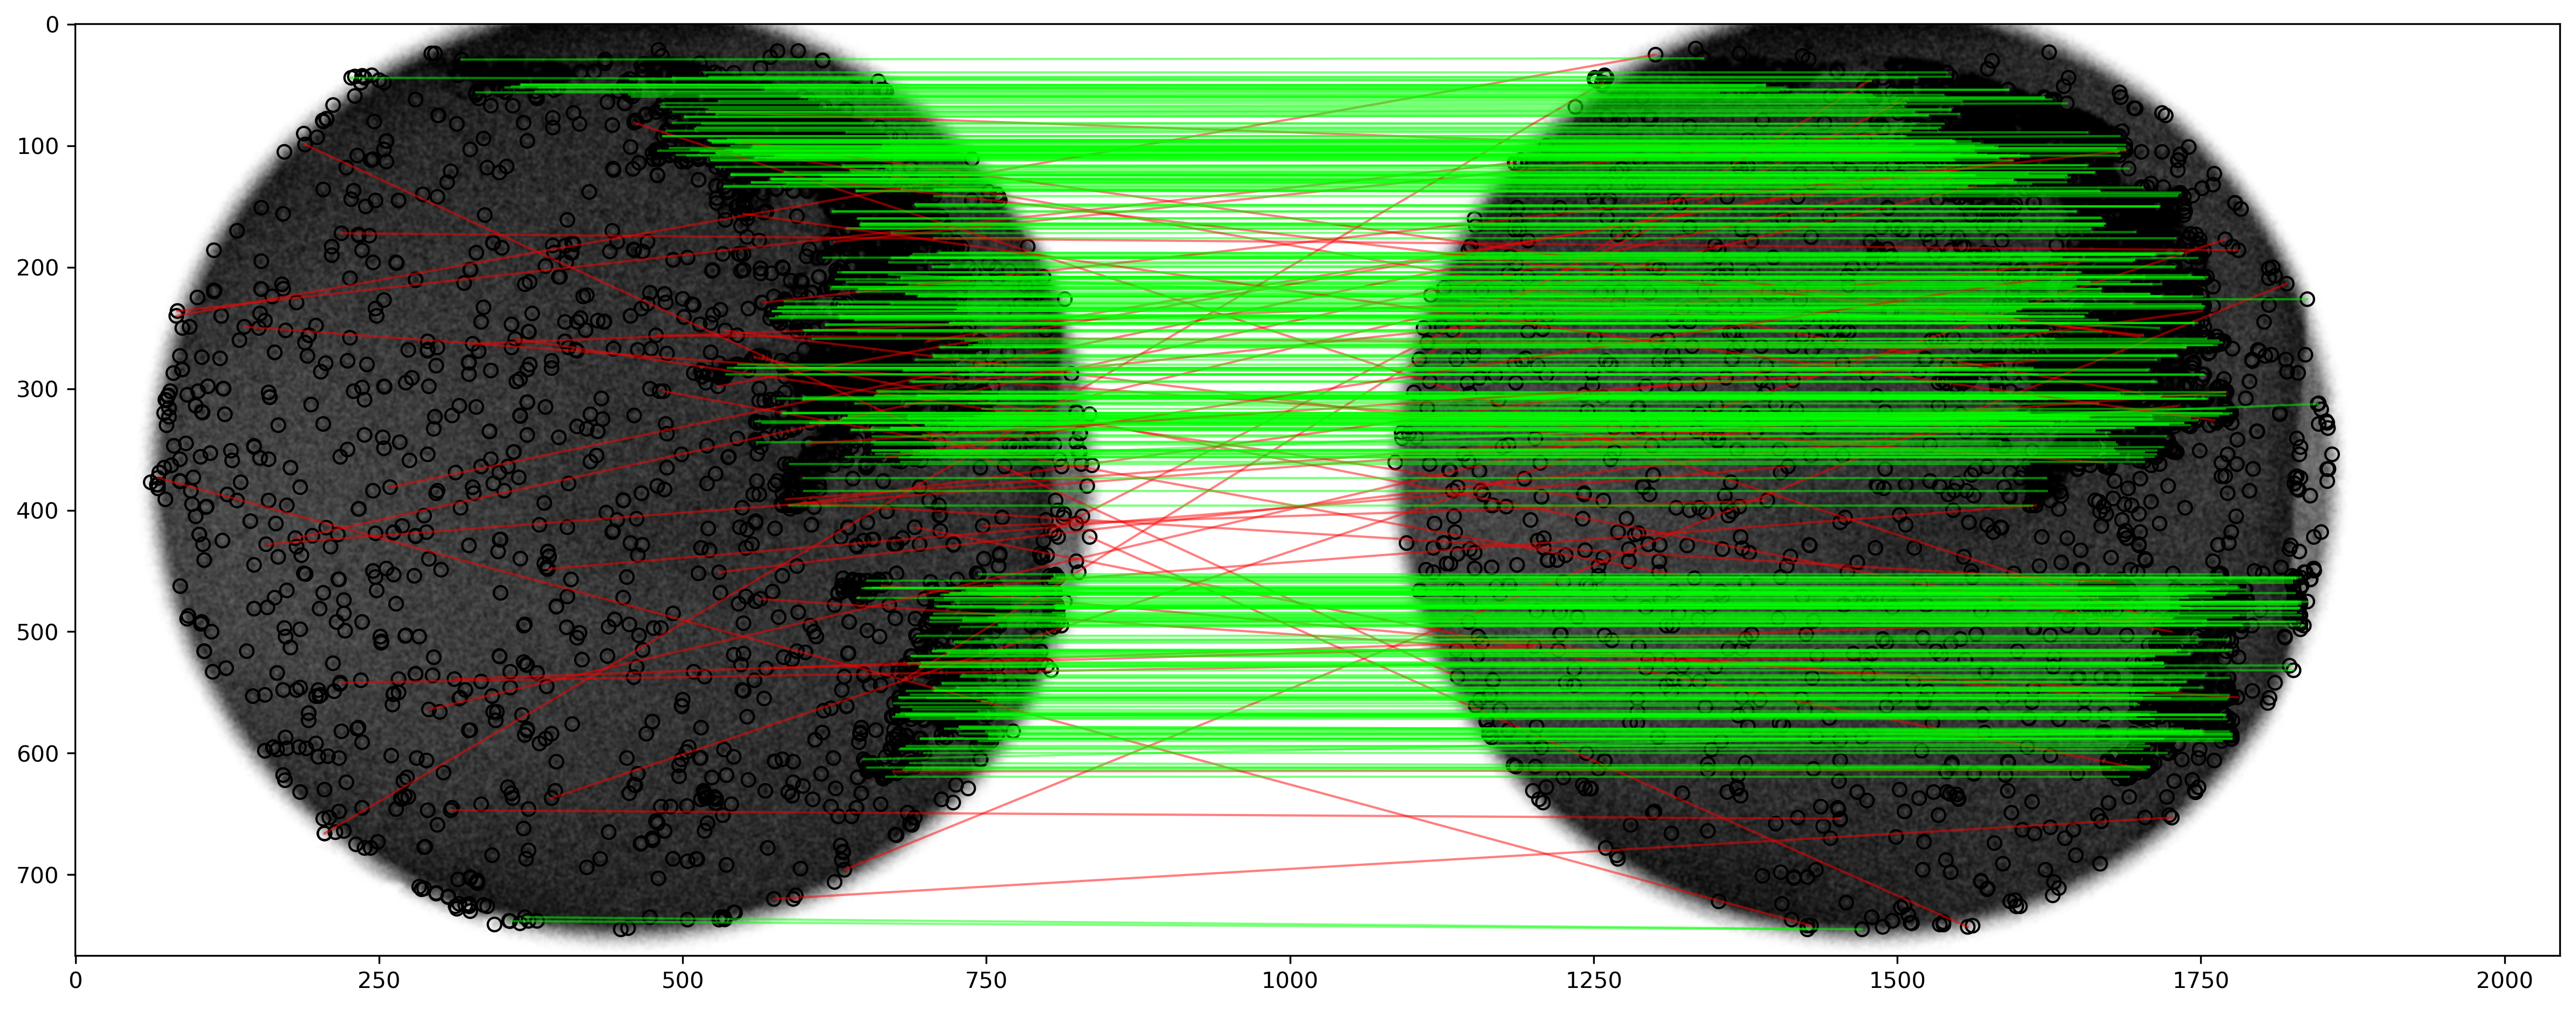

transform:
 [[ 0.99998658 -0.00518137  3.36132893]
 [ 0.00518137  0.99998658 -1.08835966]
 [ 0.          0.          1.        ]]


In [8]:
%matplotlib inline
reg.params.update({
    'transform_type': 'affine',
    'method': {
        'name': 'orb',	# 'sift' or 'orb'
        'gaussian_sigma': 1,
        'max_keypoints': 5000,
        'inlier_threshold_factor': 0.05,
        'max_trials': 1000,
        'ransac_iterations': 3
    }
})

reg_method, pairwise_reg_func, pairwise_reg_func_kwargs = reg.create_registration_method(sims[0])
result = pairwise_reg_func(overlap1, overlap2)
print('transform:\n', result['affine_matrix'])

## Run registration on all tiles, showing results corresponding to each tile overlap

In [ ]:
%matplotlib inline
reg.register(sims, norm_sims)